## Daily LightGBM

The goal is to reduce the hourly noise and predict the daily consumption and then decompose the daily predictions into hourly

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/../..")
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram, nmae, nmae_scorer, mape_scorer, mean_squared_error_scorer, corr_metric_scorer
from data_processing import DataProcessAggregateDaily
from typing import Dict
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
#models
import statsmodels.api as sm
import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm

#vis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

## Read Data

In [2]:
meta, data =pd.read_pickle("../../data/forecast_data_2020.p")

In [3]:
cluster_idx = pd.read_csv("../../data/cluster_idx.csv")

In [4]:
homes_indexes = data.columns.get_level_values(0).unique()

In [5]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Aggregate to Daily per house

In [6]:
data_daily = DataProcessAggregateDaily(data,meta).main(generate_feature=False)

In [7]:
data_daily["123"]

consumption  avg_temperature  avg_humidity  avg_cloudiness
agg_index                                                             
2020-01-01       92.775         4.858750     73.708333       99.666667
2020-01-02       54.600         5.633750     83.916667       78.125000
2020-01-03       68.860         5.482917     73.625000       38.041667
2020-01-04       90.112         2.331250     54.416667       19.708333
2020-01-05       84.545         2.391250     82.708333       92.083333
...                 ...              ...           ...             ...
2020-12-27       57.244         3.920417     94.500000       99.958333
2020-12-28       98.480         1.287917     95.416667       99.791667
2020-12-29       76.199         2.454167     95.708333       99.083333
2020-12-30       60.747         1.587083     99.916667       97.791667
2020-12-31       81.437         0.443333     99.541667       98.166667

[366 rows x 4 columns]

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h, since we workd on daily data now, thus we need to shift by 2 days

In [8]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-2),fe.CastType(float), fe.ApplyLogTransformation())

### Current consumption
consumption at step T-1 won't require any shift

In [9]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float), fe.ApplyLogTransformation())
rolling_mean = fe.make_union(*(make_pipeline(fe.FeatureSelector('consumption'),fe.CastType(float),fe.ApplyLogTransformation(), fe.ApplyRollingWindowMean(i) ) for i in range(2,8)))

### Weather

Note all weather prediction for T is given at step T, thus we need to shift for 2d the same as target 

In [10]:
temperature = make_pipeline(fe.FeatureSelector('avg_temperature'), fe.CalcShift(-2), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('avg_humidity'), fe.CalcShift(-2), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('avg_cloudiness'), fe.CalcShift(-2), fe.CastType(float))

### Exctract WeekDay

In [11]:
week_day =  make_pipeline(fe.FeatureSelector('agg_index'), fe.ExtractWeekDay(), fe.OneHot(drop_first=True))

### Extract season name from date

In [12]:
season = make_pipeline(fe.FeatureSelector('agg_index'), fe.ExtractSeason(), fe.OneHot(drop_first=True))

### Combine Features

In [13]:
feature_union = fe.make_union(prev_consumption,
                              temperature,
                              humidity,
                              cloudiness,
                              week_day,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='avg_temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-2)),
                                                      ('ca...
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='agg_index')),
                                                      ('extractseason',
                                                       ExtractSeason()),
                                                      ('onehot',
                                                       OneHot(drop_first=True))])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-2)),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())]))])

## Transform

In [168]:
def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in list(home_indexes_subsample):
        if home_i in ["268"]: # outlier
            continue
        temp_df = data_daily[home_i]
        temp_df["agg_index"] = temp_df.index
        temp_df = feature_union.fit_transform(temp_df)
        rolling_mean_ = rolling_mean.fit_transform(data_daily[home_i])
        temp_df = temp_df.merge(rolling_mean_, left_index=True, right_index=True, how="inner")
        temp_df["ev"] = meta[home_i]["has_electric_vehicle"] +0
        temp_df["cluster_idx"] = cluster_idx["clusters"][cluster_idx["home_num"] == int(home_i)].values[0]
        temp_df["home_num"] = home_i

        df_dict[home_i] = temp_df
    return df_dict

#Train data
train_homes_indexes_subsample = np.random.choice(homes_indexes,80,replace =False)
df_dict_train = create_samples(train_homes_indexes_subsample)
df_train = combine_data(df_dict_train)

#Test data
test_homes_indexes_subsample = [i for i in homes_indexes if i not in train_homes_indexes_subsample]
df_dict_test = create_samples(test_homes_indexes_subsample)
df_test = combine_data(create_samples(df_dict_test))

In [15]:
df_train.columns

Index(['consumption', 'forward_avg_temperature_2', 'forward_avg_humidity_2',
       'forward_avg_cloudiness_2', 'week_day_workday', 'season_Spring',
       'season_Summer', 'season_Winter', 'forward_consumption_2',
       'rolling_mean_2_consumption', 'rolling_mean_3_consumption',
       'rolling_mean_4_consumption', 'rolling_mean_5_consumption',
       'rolling_mean_6_consumption', 'rolling_mean_7_consumption', 'ev',
       'cluster_idx', 'home_num'],
      dtype='object')

In [16]:
FEATURES = ['consumption', 'forward_avg_temperature_2', 'forward_avg_humidity_2',
       'forward_avg_cloudiness_2', 'week_day_workday', 'season_Spring',
       'season_Summer', 'season_Winter',
       'rolling_mean_7_consumption', 'ev', 'cluster_idx']
TARGET = 'forward_consumption_2'

In [17]:
# Since we transformed the problem from Time-Series to Tabular, we allowed to shuffle it
df_train = shuffle(df_train)
df_test = shuffle(df_test)
# df_train = df_train.reset_index().sort_values(by=["time","home_num"]).set_index("time")
# df_test = df_test.reset_index().sort_values(by=["time","home_num"]).set_index("time")

X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test, y_test = df_test[FEATURES], df_test[TARGET]

In [18]:
print(X_train.shape)

(28282, 11)


In [19]:
print(X_test.shape)

(7160, 11)


In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28282 entries, 2020-08-09 to 2020-06-17
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   consumption                 28282 non-null  float64
 1   forward_avg_temperature_2   28282 non-null  float64
 2   forward_avg_humidity_2      28282 non-null  float64
 3   forward_avg_cloudiness_2    28282 non-null  float64
 4   week_day_workday            28282 non-null  uint8  
 5   season_Spring               28282 non-null  uint8  
 6   season_Summer               28282 non-null  uint8  
 7   season_Winter               28282 non-null  uint8  
 8   rolling_mean_7_consumption  28282 non-null  float64
 9   ev                          28282 non-null  int64  
 10  cluster_idx                 28282 non-null  int64  
dtypes: float64(5), int64(2), uint8(4)
memory usage: 1.8+ MB


## Check Params Linear Signifance

In [21]:
mod = sm.OLS(y_train[:3000],X_train.iloc[:3000],prepend=True)
res = mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     forward_consumption_2   R-squared (uncentered):                   0.996
Model:                               OLS   Adj. R-squared (uncentered):              0.996
Method:                    Least Squares   F-statistic:                          6.390e+04
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):                        0.00
Time:                           16:56:55   Log-Likelihood:                         -404.77
No. Observations:                   3000   AIC:                                      831.5
Df Residuals:                       2989   BIC:                                      897.6
Df Model:                             11                                                  
Covariance Type:               nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.

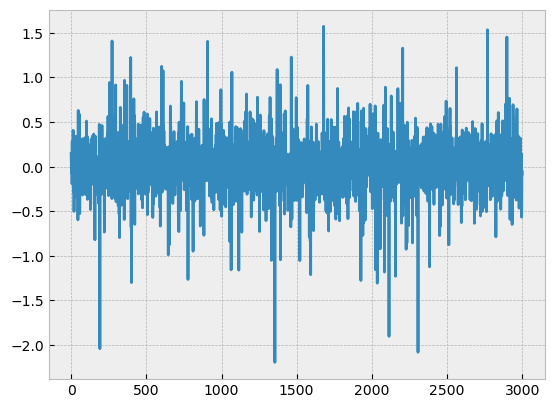

In [22]:
plt.plot(res.resid.values)

## Model LIGHTGBM

In [23]:
def cross_validation_time_series(estimator: callable,
                                 X: pd.DataFrame,
                                 y: pd.DataFrame,
                                 cv: int,
                                 params: Dict,
                                 scoring: callable):
    global train_index, test_index
    tscv = TimeSeriesSplit(n_splits=cv)
    val_scores = []
    for train_index, test_index in tscv.split(X):
        train_index_max = train_index[-1]
        test_index_max = test_index[-1]
        X_train, X_val = X.iloc[:train_index_max], X.iloc[train_index_max: test_index_max]
        y_train, y_val = y.iloc[:train_index_max], y.iloc[train_index_max: test_index_max]
        model = estimator(**params)
        model.fit(X_train, y_train)
        
        val_scores.append(scoring(model, X_val, y_val))
    return val_scores


def cross_validation(estimator: callable,
                     X: pd.DataFrame,
                     y: pd.DataFrame,
                     cv: int,
                     params: Dict,
                     scoring: callable):
    regressor = estimator(**params)
    scores = cross_val_score(estimator=regressor,
                             X=X,
                             y=y,
                             cv=cv,
                             scoring=scoring)
    return scores

# Setup objective function
def objective(params):
    scores = cross_validation(**params["cv_config"],
                              params=params["space"])  
    return np.mean(scores)

In [24]:
SCORING = nmae_scorer
CV_CONFIG = {"estimator": lgb.LGBMRegressor,
             "X": X_train,
             "y": y_train,
             "cv": 10,
             "scoring": SCORING
            }

# Informative Priors
space = {
    'learning_rate':    hp.uniform('learning_rate', 0.2, 1),
    'num_leaves':       scope.int(hp.uniform('num_leaves', 2, 8)),
    'max_depth':        scope.int(hp.uniform('max_depth', 1, 5)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1), #feature_fraction
    'num_iterations':   scope.int(hp.uniform('num_iterations',50, 100)),
    'reg_alpha':        hp.uniform("reg_alpha",0, 0.2), #L1
    'reg_lambda':        hp.uniform("reg_lambda",0, 1), #L2
    'seed': random_state
        }
#best
# {'colsample_bytree': 0.9137395568134581,
#  'learning_rate': 0.2172447280537097,
#  'max_depth': 4.083845323208164,
#  'num_iterations': 76.20448034931451,
#  'num_leaves': 7.526949273421604,
#  'reg_alpha': 0.10445955292256207,
#  'reg_lambda': 0.6776269498491447,
#  'subsample': 0.9420311245049422}

params = {"cv_config":CV_CONFIG,
          "space": space}


    
def customStopCondition(x, *kwargs):
    return abs(x.best_trial["result"]["loss"]) < 0.001, kwargs
    
trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            early_stop_fn=customStopCondition)
best

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.24trial/s, best loss: 0.04276242448421254]


{'colsample_bytree': 0.9137395568134581,
 'learning_rate': 0.2172447280537097,
 'max_depth': 4.083845323208164,
 'num_iterations': 76.20448034931451,
 'num_leaves': 7.526949273421604,
 'reg_alpha': 0.10445955292256207,
 'reg_lambda': 0.6776269498491447,
 'subsample': 0.9420311245049422}

#### Re-Train the Model with best Params

In [25]:
int_col_names = ["max_depth", "num_iterations","num_leaves","n_estimators"]
def map_to_int(params):
    params_mapped = {}
    for key, val in params.items():
        if key in int_col_names:
            params_mapped[key] = round(val)
        else:
            params_mapped[key] = val
    return params_mapped
        
best_params = map_to_int(best)

model = CV_CONFIG["estimator"](**best_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9137395568134581,
              learning_rate=0.2172447280537097, max_depth=4, num_iterations=76,
              num_leaves=8, reg_alpha=0.10445955292256207,
              reg_lambda=0.6776269498491447, subsample=0.9420311245049422)

In [26]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index

int_col_names = ["max_depth", "num_iterations","num_leaves"]
for col_name in int_col_names:
    trials_df[col_name] = trials_df[col_name].apply(lambda x: round(x))

In [27]:
trials_df.head(5)

colsample_bytree  learning_rate  max_depth  num_iterations  num_leaves  \
0          0.721072       0.689221          4              98           7   
1          0.999400       0.915084          3              93           5   
2          0.874522       0.814649          3              63           4   
3          0.869796       0.732832          3              94           3   
4          0.676881       0.540664          4              55           7   

   reg_alpha  reg_lambda  subsample      loss  trial_number  
0   0.192209    0.129801   0.862634  0.043246             0  
1   0.147826    0.585347   0.916993  0.043212             1  
2   0.104550    0.573790   0.905296  0.043185             2  
3   0.034209    0.441505   0.840956  0.044499             3  
4   0.161605    0.731538   0.861488  0.043059             4

#### Trials vs Objective Func

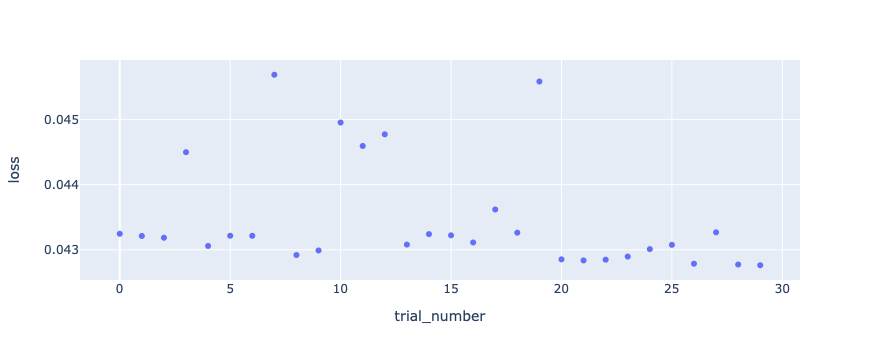

In [28]:
px.scatter(trials_df, x="trial_number", y="loss")

#### Contour plot
Feature vs Objective Func

Num Leaves vs Num Iteration

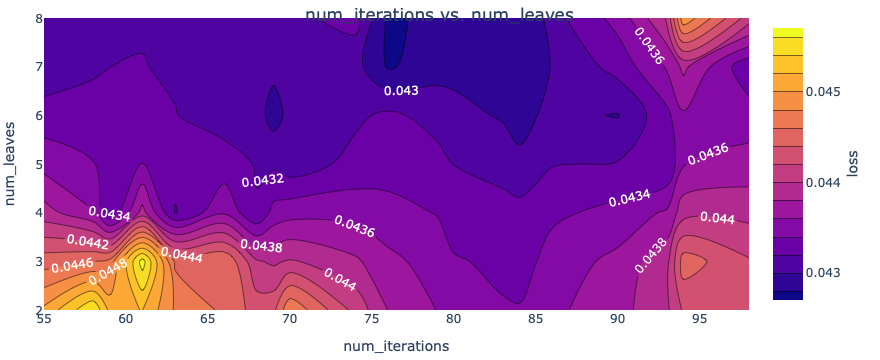

In [29]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["loss"],
        x=trials_df["num_iterations"],
        y=trials_df["num_leaves"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="loss", titleside="right",),
        hovertemplate="loss: %{z}<br>num_iterations: %{x}<br>num_leaves: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="num_leaves",
    title={
        "text": "num_iterations vs. num_leaves",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

learning_rate vs num_iterations

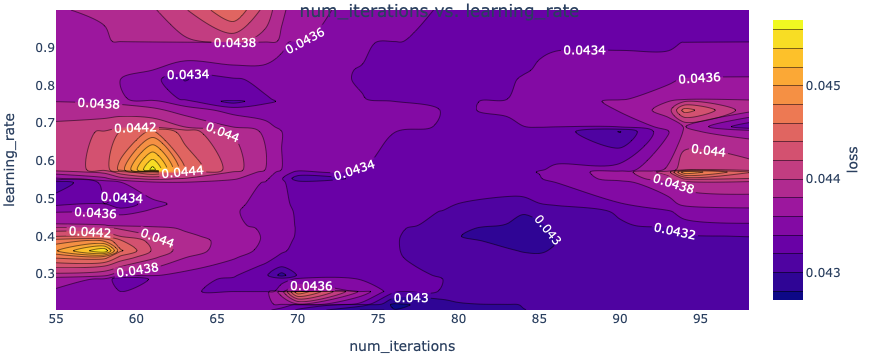

In [30]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["loss"],
        x=trials_df["num_iterations"],
        y=trials_df["learning_rate"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="loss", titleside="right",),
        hovertemplate="loss: %{z}<br>num_iterations: %{x}<br>learning_rate: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="learning_rate",
    title={
        "text": "num_iterations vs. learning_rate",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

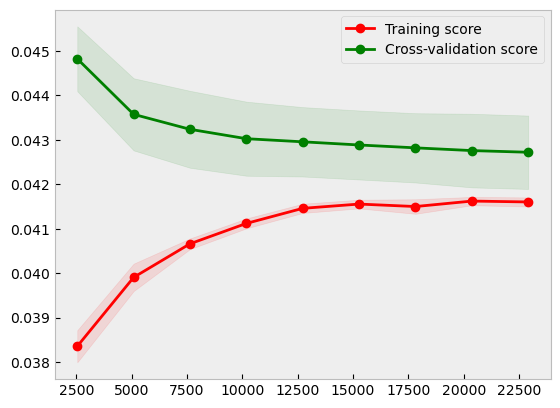

In [31]:
train_sizes, train_scores, test_scores =learning_curve(model,
                                                       X_train,
                                                       y_train,
                                                       scoring=SCORING,
                                                       train_sizes=np.array([i/10 for i in range(1,10)]),
                                                       cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
plt.legend(loc="best")

Text(0.5, 1.0, 'Top 20 feature imporance')

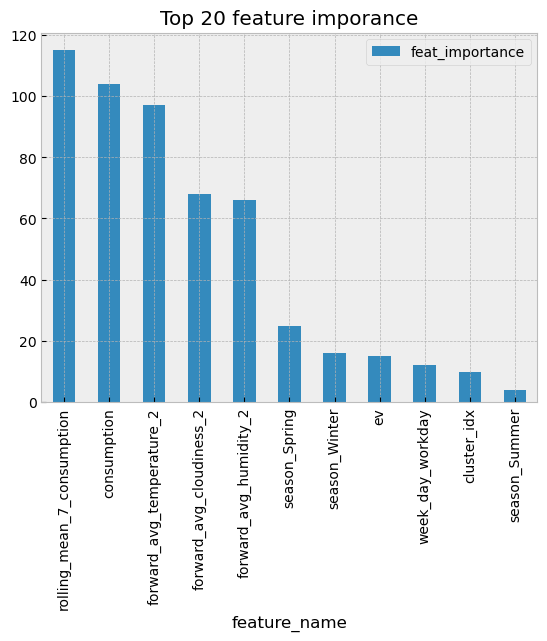

In [32]:
top = 20
df_feat = (
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

## Hyper Parameter Significance

In [33]:
ols = sm.OLS(endog=trials_df['loss'], exog=trials_df.drop(['loss','trial_number'], axis=1)).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                   loss   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              1291.
Date:                Sat, 08 Oct 2022   Prob (F-statistic):                    1.45e-27
Time:                        16:57:19   Log-Likelihood:                          143.81
No. Observations:                  30   AIC:                                     -271.6
Df Residuals:                      22   BIC:                                     -260.4
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Model Interperation Partial Depedency
Note: Correlation and mutual depedency in between features are ignored

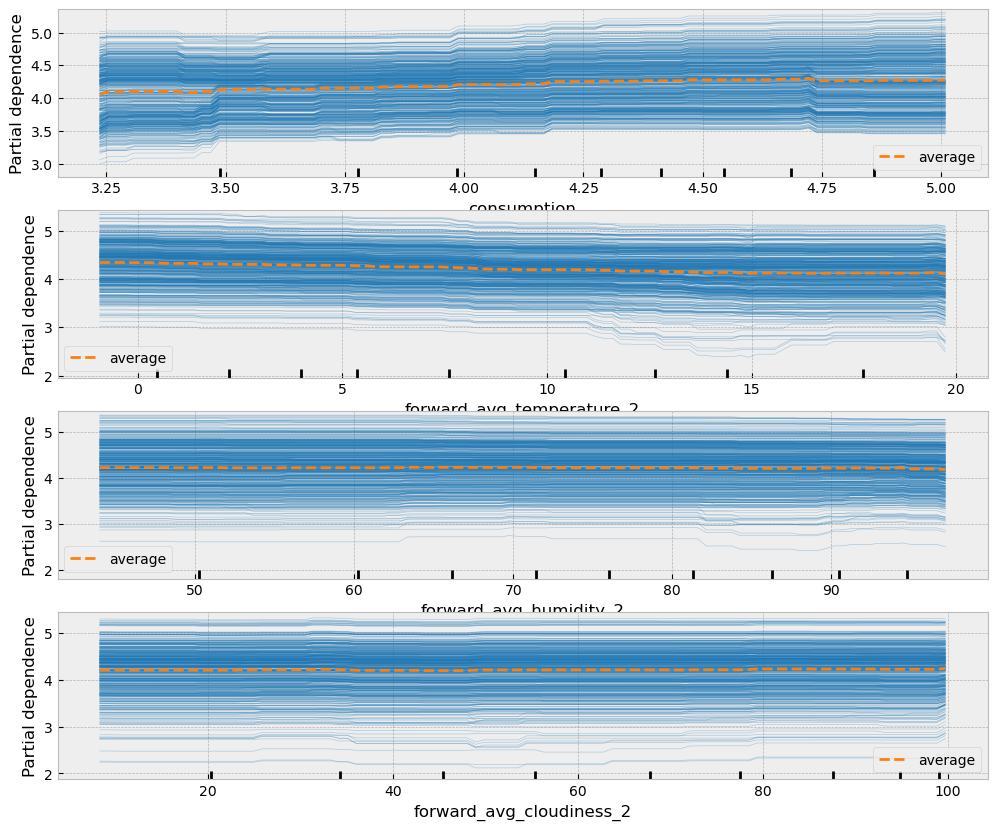

In [34]:
num_feat = 4
fig, ax = plt.subplots(num_feat,1, figsize=(12, 10))
for i in range(num_feat):
    feat = df_feat["feature_name"][i]
    PartialDependenceDisplay.from_estimator(model, X_train, [feat], kind='both', ax=ax[i],subsample=500)

# Model Prediction on DAILY Consumption
## Model Prediction on Individual House Train

In [35]:
df_dict_train.keys()

dict_keys(['246', '859', '618', '987', '744', '404', '464', '241', '743', '854', '598', '255', '299', '993', '222', '424', '412', '677', '260', '906', '290', '583', '604', '644', '980', '340', '123', '244', '192', '219', '890', '118', '875', '621', '131', '460', '480', '484', '363', '657', '595', '313', '666', '188', '957', '947', '763', '554', '780', '438', '822', '927', '250', '272', '600', '852', '267', '999', '629', '514', '745', '889', '601', '261', '130', '231', '640', '992', '113', '801', '462', '525', '977', '318', '441', '909', '351', '683', '912'])

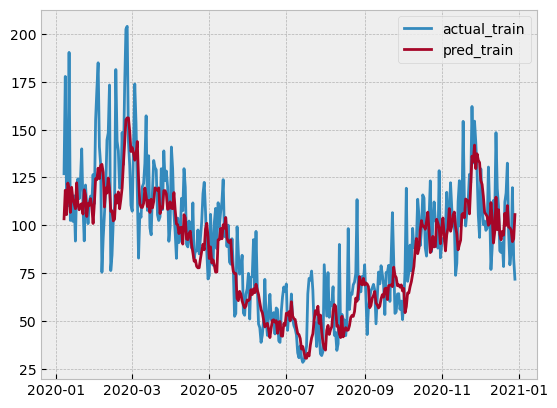

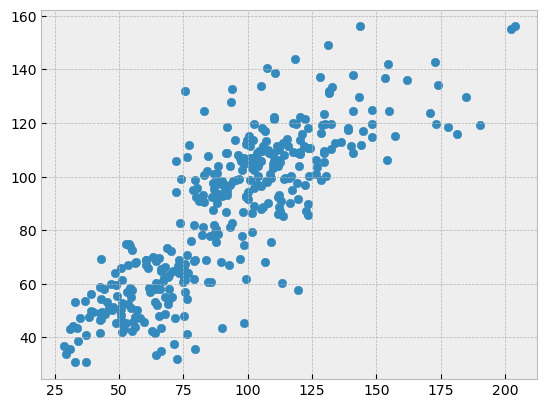

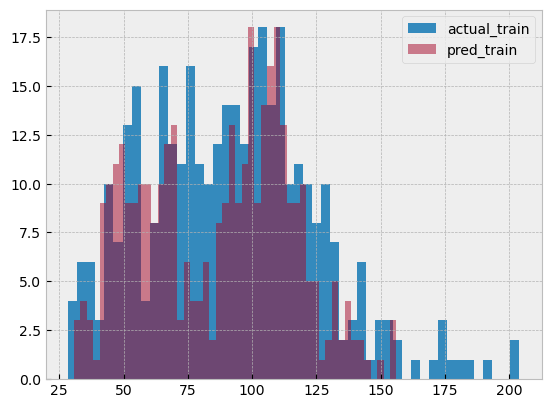

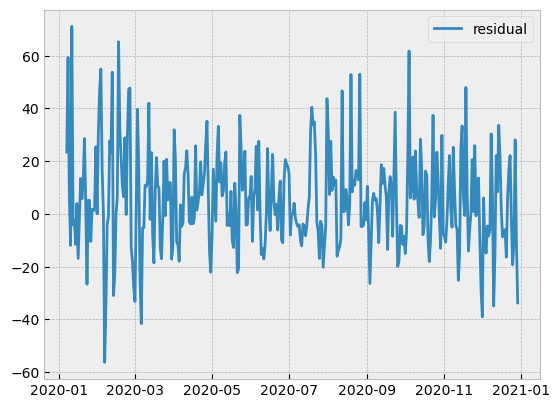

In [56]:
home_num = '246'
X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
pred = model.predict(X_train)
pred_home_train_single = pd.DataFrame({
                            # "actual": y_train,
                            # "pred": pred,
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =50)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =50)
plt.legend()
plt.show()

plt.plot(pred_home_train_single["actual"]-pred_home_train_single["pred"], label="residual")
plt.legend()
plt.show()

In [37]:
nmae(pred_home_train_single["actual"],pred_home_train_single["pred"])

0.1477523690291413

## Model Prediction on Individual House Test

In [38]:
df_dict_test.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

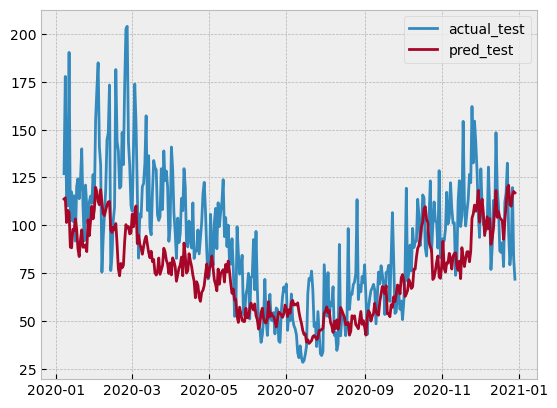

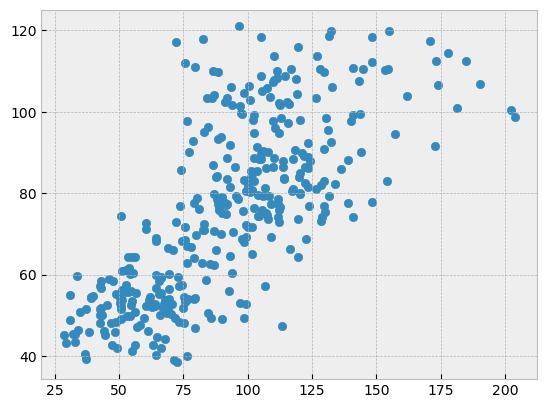

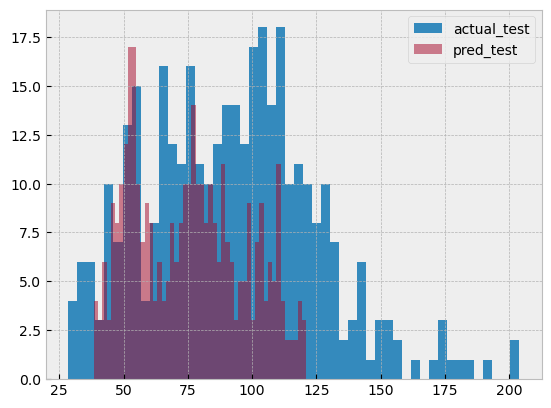

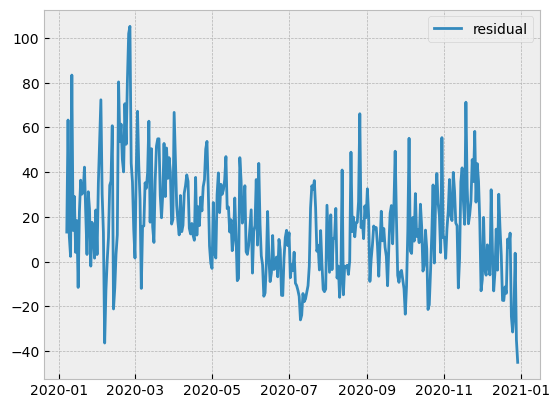

In [59]:
home_num = '522'
X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
pred = model.predict(X_test)
pred_home_test_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_test_single["actual"], label="actual_test")
plt.plot(pred_home_test_single["pred"], label="pred_test")
plt.legend()
plt.show()

plt.scatter(pred_home_test_single["actual"].values,pred_home_test_single["pred"].values) 
plt.show()


plt.hist(pred_home_test_single["actual"], label="actual_test", bins = 50)
plt.hist(pred_home_test_single["pred"], label="pred_test",alpha =0.5, bins = 50)
plt.legend()
plt.show()

plt.plot(pred_home_test_single["actual"]-pred_home_test_single["pred"], label="residual")
plt.legend()
plt.show()

In [60]:
nmae(pred_home_test_single["actual"],pred_home_test_single["pred"])

0.2358370421544384

# Porfolio prediction on Train Data Set

In [61]:
pred_home_train = {}
for home_num in df_dict_train.keys():
    X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
    pred = model.predict(X_train)
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_train)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [62]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="agg_index").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="agg_index").sum(axis=1)

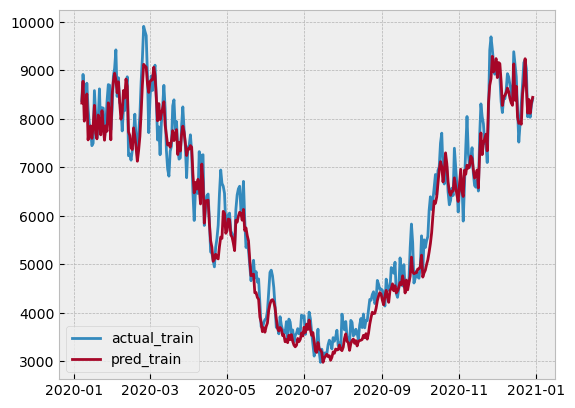

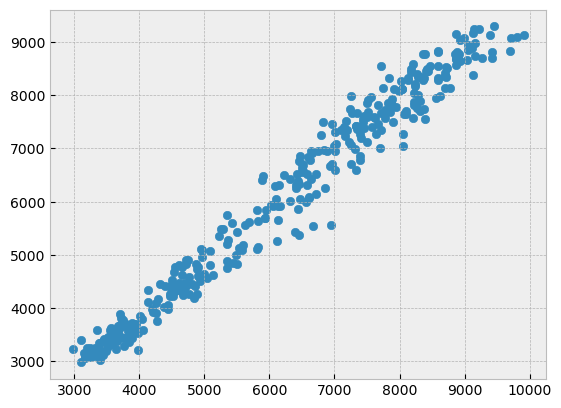

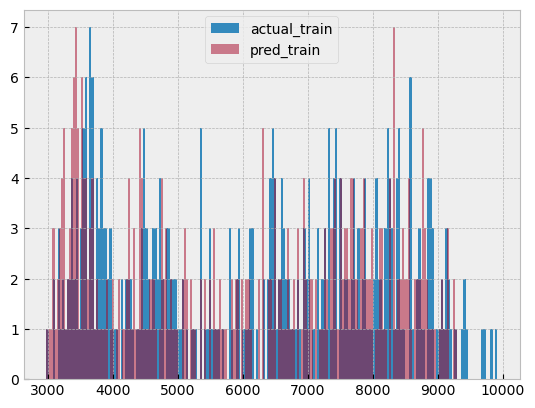

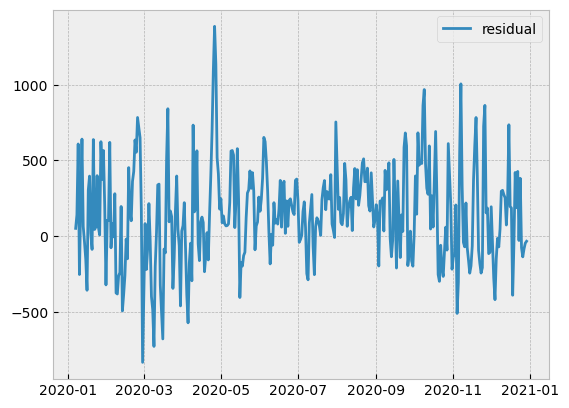

In [63]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_train-portfolio_pred_train, label="residual")
plt.legend()
plt.show()

In [65]:
nmae(portfolio_actual_train,portfolio_pred_train)

0.04419624354333215

# Porfolio prediction on Test Data Set

In [46]:
df_dict_test.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

In [66]:
pred_home_test = {}
for home_num in df_dict_test.keys():
    X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
    pred = model.predict(X_test)
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_test)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [67]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="agg_index").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="agg_index").sum(axis=1)

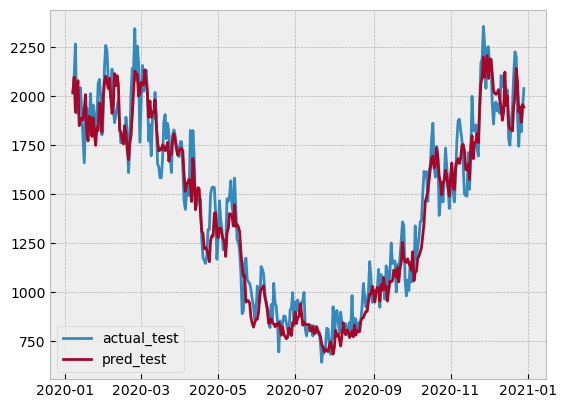

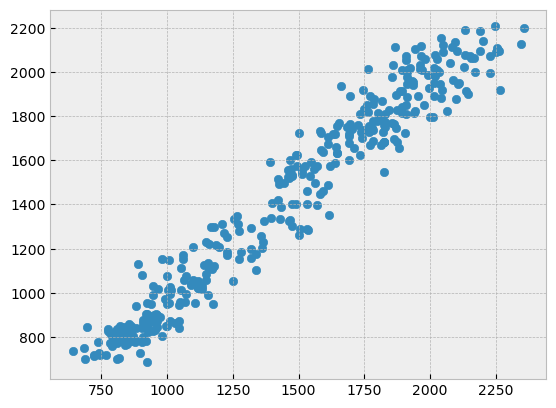

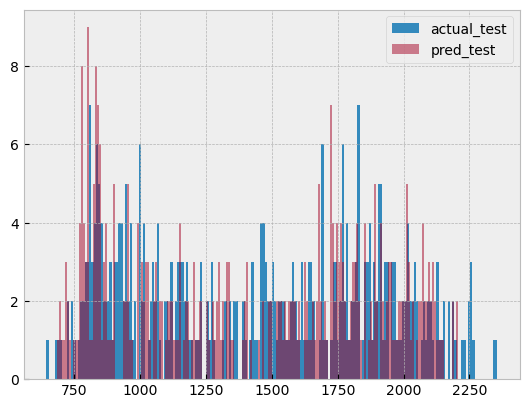

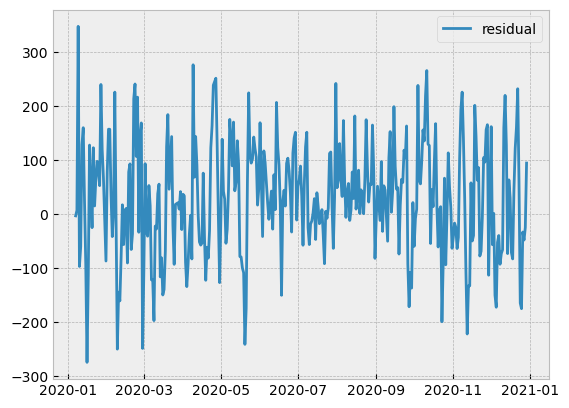

In [68]:
plt.plot(portfolio_actual_test, label="actual_test")
plt.plot(portfolio_pred_test, label="pred_test")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()


plt.hist(portfolio_actual_test, label="actual_test", bins = 200)
plt.hist(portfolio_pred_test, label="pred_test",alpha =0.5, bins = 200)
plt.legend()
plt.show()

plt.plot(portfolio_actual_test-portfolio_pred_test, label="residual")
plt.legend()
plt.show()

In [69]:
nmae(portfolio_actual_test,portfolio_pred_test)

0.05909733194540248

# Decompose to Hourly Consumption Prediction

The most simple model for decomposition from daily to hourly will be just simple ratio per hour time

<BarContainer object of 24 artists>

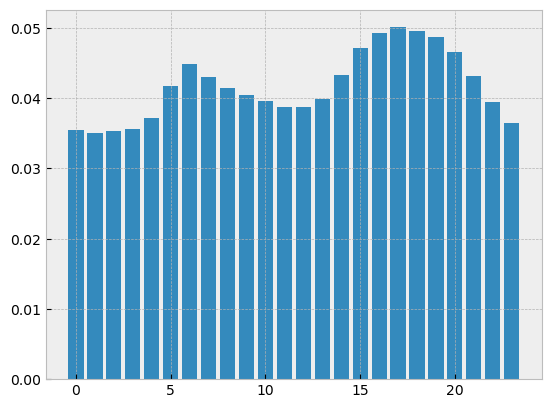

In [110]:
hourly_ratio_con = {}
#better to use another data set (not train nor test) but due to having only 100 samples we will use train
for hom_num in train_homes_indexes_subsample:
    temp_df = data[hom_num].copy()
    temp_df["hour"]=temp_df.reset_index()["time"].dt.hour.values
    hourly_ratio_con[hom_num] = temp_df.groupby("hour")["consumption"].sum()
hourly_ratio_con = (pd.DataFrame(dict_hourly_ratio_con).sum(axis=1) / 
                         pd.DataFrame(dict_hourly_ratio_con).sum(axis=1).sum())
plt.bar(hourly_ratio_con.index, hourly_ratio_con)

In [111]:
hourly_ratio_con = hourly_ratio_con.to_dict()

In [204]:
hourly_ratio_con.values

<function dict.values>

## Combine Hourly and Daily predictions

#### Create Target for Hourly

In [116]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float),fe.ApplyLogTransformation())

In [224]:
FULL_TRAINIG_SET = df_dict_train | df_dict_test

def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in tqdm.tqdm(list(home_indexes_subsample)):
        if home_i == "268": # outlier
            continue
        temp_df= (data[home_i].
                  copy().
                  reset_index().
                  drop_duplicates(subset='time', keep="last").
                  set_index("time"))
        temp_df = target.fit_transform(temp_df)
        temp_df["time_index"] = temp_df.index.values
        temp_df["date"]=temp_df["time_index"].dt.date.values
        temp_df["hour"]= temp_df["time_index"].dt.hour.values
        temp_df["hour_avg_con_ratio"] = temp_df["hour"].apply(lambda x: hourly_ratio_con[x])
        pred = pd.DataFrame({"pred_daily": model.predict(FULL_TRAINIG_SET[home_i][FEATURES]),
                             "date": FULL_TRAINIG_SET[home_i][TARGET].index
                            })
        
        temp_df=temp_df.merge(pred, left_on ="date", right_on ="date")
        temp_df["pred_hourly"] = (np.exp(temp_df["pred_daily"])-0.01) * temp_df["hour_avg_con_ratio"]
        temp_df["forward_consumption_48"] = np.exp(temp_df["forward_consumption_48"])-0.01
        temp_df["home_i"] = home_i
        df_dict[home_i] = temp_df      
    return df_dict

#Train data
df_dict_train_hourly = create_samples(train_homes_indexes_subsample)

#Test data
df_dict_test_hourly = create_samples(test_homes_indexes_subsample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 48.51it/s]


## Model Prediction on Individual House Train

In [222]:
df_dict_train_hourly.keys()

dict_keys(['246', '859', '618', '987', '744', '404', '464', '241', '743', '854', '598', '255', '299', '993', '222', '424', '412', '677', '260', '906', '290', '583', '604', '644', '980', '340', '123', '244', '192', '219', '890', '118', '875', '621', '131', '460', '480', '484', '363', '657', '595', '313', '666', '188', '957', '947', '763', '554', '780', '438', '822', '927', '250', '272', '600', '852', '267', '999', '629', '514', '745', '889', '601', '261', '130', '231', '640', '992', '113', '801', '462', '525', '977', '318', '441', '909', '351', '683', '912'])

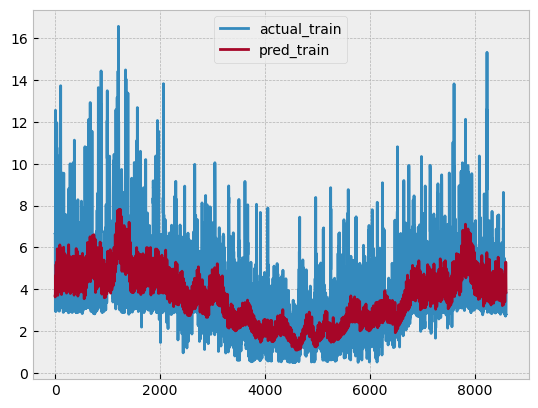

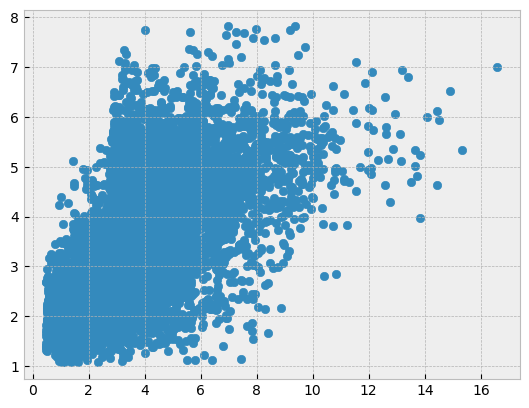

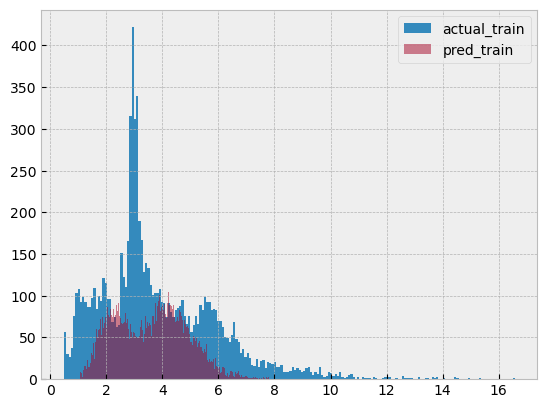

In [234]:
home_num = '246'
pred_home_train_single = pd.DataFrame({
                            "actual": df_dict_train_hourly[home_num]["forward_consumption_48"],
                            "pred": df_dict_train_hourly[home_num]["pred_hourly"],
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

In [229]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.3311051312043825

## Model Prediction on Individual House Test

In [230]:
df_dict_test_hourly.keys()

dict_keys(['319', '200', '945', '352', '521', '842', '396', '901', '238', '986', '923', '925', '456', '624', '827', '474', '194', '706', '522', '247'])

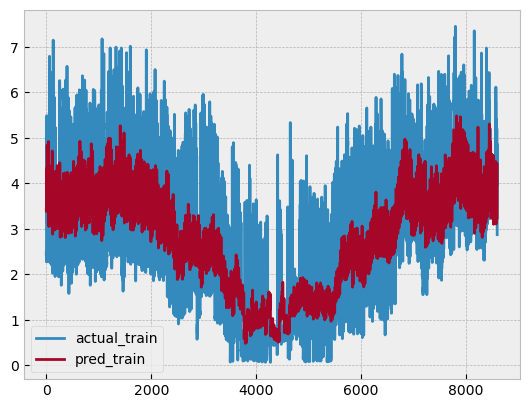

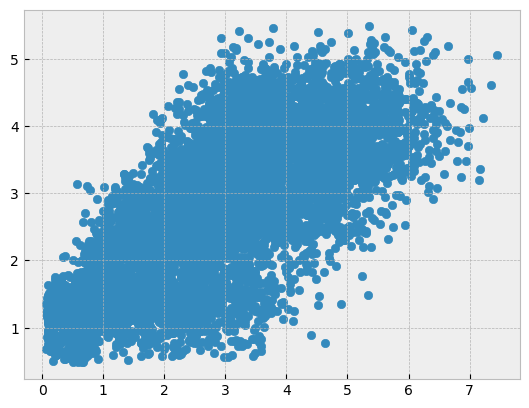

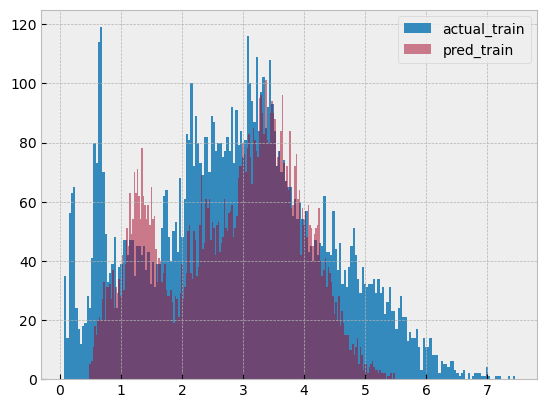

In [231]:
home_num = '319'
pred_home_train_single = pd.DataFrame({
                            "actual": df_dict_test_hourly[home_num]["forward_consumption_48"],
                            "pred": df_dict_test_hourly[home_num]["pred_hourly"],
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

In [232]:
nmae(pred_home_train_single["actual"], pred_home_train_single["pred"])

0.2822604795425493

# Porfolio prediction on Train Data Set

In [239]:
pred_home_train = {}
for home_num in df_dict_train_hourly.keys():
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": df_dict_train_hourly[home_num]["forward_consumption_48"],
                                 "pred": df_dict_train_hourly[home_num]["pred_hourly"],
                                 "home_num" : home_num,
                                 "time": df_dict_train_hourly[home_num]["forward_consumption_48"].index})                  

In [240]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

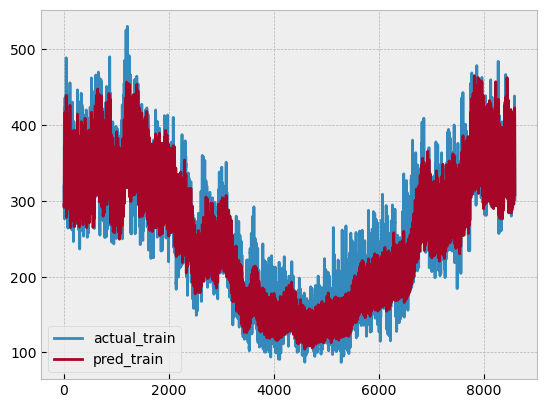

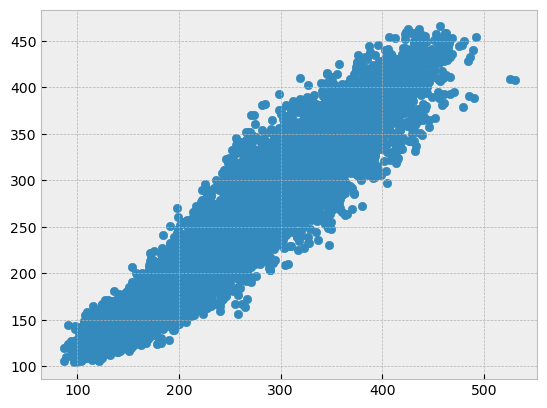

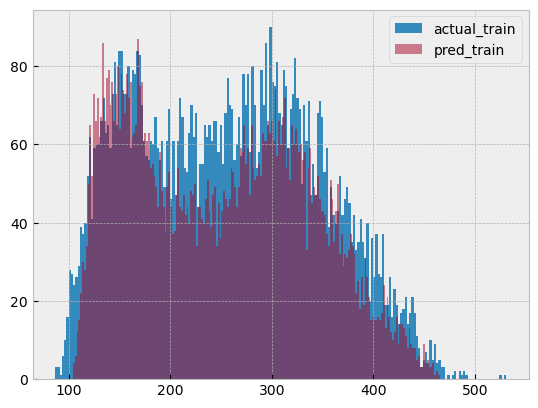

In [241]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [242]:
nmae(portfolio_actual_train, portfolio_pred_train)

0.08663643286540205

# Porfolio prediction on Test Data Set

In [243]:
pred_home_test = {}
for home_num in df_dict_test_hourly.keys():
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": df_dict_test_hourly[home_num]["forward_consumption_48"],
                                 "pred": df_dict_test_hourly[home_num]["pred_hourly"],
                                 "home_num" : home_num,
                                 "time": df_dict_test_hourly[home_num]["forward_consumption_48"].index})

In [244]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

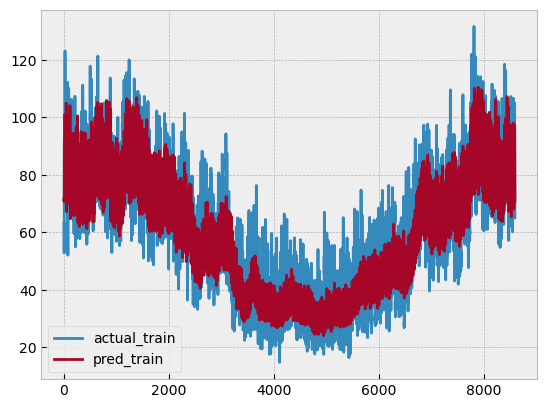

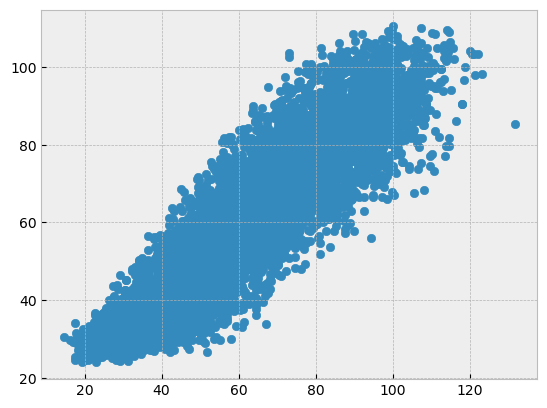

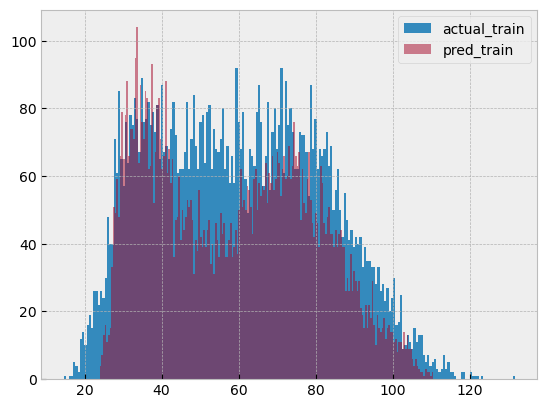

In [245]:
plt.plot(portfolio_actual_test, label="actual_train")
plt.plot(portfolio_pred_test, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()

plt.hist(portfolio_actual_test, label="actual_train", bins = 200)
plt.hist(portfolio_pred_test, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [247]:
nmae(portfolio_actual_test, portfolio_pred_test)

0.11771022408990164